#Testing out VAE on basic shapes | Circles, rectangles, triangles

Autoencoder, generation of shapes, and information rate

a. Create a database of sufficient size of 28*28 images with circles, triangles and rectangles at random locations.

b. Create a suitable variational autoencoder (VAE) for the data in the database. Motivate the network configuration  (architecture, objective functions, hyperparameters) you select. 

c. Use your VAE to generate new dataand provide a quantitative measure of the performance of your system

d. Replace your VAE with a similar but not identical system that does not use the ELBO. Instead, control the distribution of the latent layer to be iid Gaussian (eg with MMD) and add Gaussian noise with a fixed that variance you set

e. Recalling that mutual information is given by $I(X;Y) = E[log\frac{p(X,Y)}{p(X)p(Y)}]$, estimate the information passing through the latent layer, in bits. Explain what this information represents in terms of your reconstruction. 

f. Compare the performance of the systems, using suitable attributes and/or extensions.

In [16]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
import time


from keras import backend as K
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from keras.utils import np_utils
#from keras.utils import to_categorical
import PIL
from PIL import Image
from IPython import display
import imageio
import numpy as np
import os
import cv2
import random

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### Encoder network
This defines the approximate posterior distribution $q(z|x)$, which takes as input an observation and outputs a set of parameters for specifying the conditional distribution of the latent representation $z$. 
In this example, simply model the distribution as a diagonal Gaussian, and the network outputs the mean and log-variance parameters of a factorized Gaussian. 
Output log-variance instead of the variance directly for numerical stability.

### Decoder network 
This defines the conditional distribution of the observation $p(x|z)$, which takes a latent sample $z$ as input and outputs the parameters for a conditional distribution of the observation.
Model the latent distribution prior $p(z)$ as a unit Gaussian.

### Reparameterization trick
To generate a sample $z$ for the decoder during training, you can sample from the latent distribution defined by the parameters outputted by the encoder, given an input observation $x$.
However, this sampling operation creates a bottleneck because backpropagation cannot flow through a random node.

To address this, use a reparameterization trick.
In our example, you approximate $z$ using the decoder parameters and another parameter $\epsilon$ as follows:

$$z = \mu + \sigma \odot \epsilon$$

where $\mu$ and $\sigma$ represent the mean and standard deviation of a Gaussian distribution respectively. They can be derived from the decoder output. The $\epsilon$ can be thought of as a random noise used to maintain stochasticity of $z$. Generate $\epsilon$ from a standard normal distribution.

The latent variable $z$ is now generated by a function of $\mu$, $\sigma$ and $\epsilon$, which would enable the model to backpropagate gradients in the encoder through $\mu$ and $\sigma$ respectively, while maintaining stochasticity through $\epsilon$.

# Generate Shapes

In [17]:
# config values
NUM_OF_DATA = 1000

WIDTH = 28
HEIGHT = 28  #The above 3 will be used throughout

WHITE = (255,255,255)
BLACK = (0,0,0)

MIN_THICKNESS = 1.5
MAX_THICKNESS = 1.5
###

CENTER_X = WIDTH //2
CENTER_Y = HEIGHT//2

## Side Note: 

Let us make a simple function of what we have done so far in order to quickly generate a separate new dataset of a size of our choosing to test on our VAE later

Code outputs sample of 3*given number 

In [18]:
def shapeset(NUM):
  tri = []
  Vary = 3.5  #Vary the size of the shapes
  for _ in range(NUM):
      img = np.zeros((WIDTH, HEIGHT, 3), np.uint8) + 255


  #triangles
      t_height = Vary*HEIGHT//5
      t_width  =  Vary*WIDTH //5
      t_dir    = 1  #This sets the triangle to be right ways up or upside down (-1)
      #Random center
      x_bias = random.randint(t_width - WIDTH, WIDTH - t_width)//2
      y_bias = random.randint(t_height - HEIGHT, HEIGHT - t_height)//2

      t_thickness = np.int32(1)

      vertices = np.array([
          [CENTER_X + x_bias, CENTER_Y + t_height//2 * t_dir + y_bias],
          [CENTER_X - t_width//2 + x_bias, CENTER_Y - t_height//2 * t_dir + y_bias],
          [CENTER_X + t_width//2 + x_bias, CENTER_Y - t_height//2 * t_dir + y_bias]
      ])
      pts = vertices.reshape((-1, 1, 2))
      cv2.polylines(img,np.int32([pts]), isClosed = True, color = BLACK, thickness = t_thickness)

      tri.append([img, np.int(3)]) #label to indicate shape
  rect = []
  for _ in range(NUM):
      img = np.zeros((WIDTH, HEIGHT, 3), np.uint8) + 255

  #rectangles
      r_height = Vary*HEIGHT//5
      r_width  = Vary*WIDTH //5

      #Random center
      x_bias = random.randint(r_width - WIDTH, WIDTH - r_width)//2
      y_bias = random.randint(r_height - HEIGHT, HEIGHT - r_height)//2

      r_thickness = np.int32(1)

      vertices = np.array([
          [CENTER_X + r_width//2 + x_bias, CENTER_Y + r_height//2 + y_bias],
          [CENTER_X - r_width//2 + x_bias, CENTER_Y + r_height//2 + y_bias],
          [CENTER_X - r_width//2 + x_bias, CENTER_Y - r_height//2 + y_bias],
          [CENTER_X + r_width//2 + x_bias, CENTER_Y - r_height//2 + y_bias]
      ])
      pts = vertices.reshape((-1, 1, 2))
      cv2.polylines(img, np.int32([pts]), isClosed = True, color = BLACK, thickness = r_thickness)

      rect.append([img, np.int(4)])
  circ = []
  for _ in range(NUM):
      img = np.zeros((WIDTH, HEIGHT, 3), np.uint8) + 255

  #circles
      c_rad = 13

      c_thickness = MIN_THICKNESS/2

      x_bias = random.randint(c_rad * 2 - WIDTH, WIDTH - c_rad * 2)//2
      y_bias = random.randint(c_rad * 2 - HEIGHT, HEIGHT - c_rad * 2)//2

      cv2.circle(img,
          center = (CENTER_X + x_bias, CENTER_Y + y_bias),
          radius = c_rad,
          color = BLACK,
          thickness = r_thickness
      )

      circ.append([img,np.int(0)])

  tot_data = []
  for t in tri: tot_data.append([cv2.cvtColor(t[0],cv2.COLOR_BGR2GRAY),t[1]])
  for r in rect: tot_data.append([cv2.cvtColor(r[0],cv2.COLOR_BGR2GRAY),r[1]])
  for c in circ: tot_data.append([cv2.cvtColor(c[0],cv2.COLOR_BGR2GRAY),c[1]])
  random.shuffle(tot_data)

  data_x = []
  data_y = []
  for d in tot_data:
      data_x.append(d[0])
      data_y.append(d[1])

  return [data_x, data_y]

## Plot data example

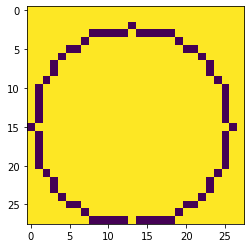

In [19]:
tryoutdata_x = shapeset(10)[0] #First component is the x data to plot, second component is just the category, so only want to plot the first component
plt.imshow(tryoutdata_x[0]) #print out the first dataset of 10 generated

### Set number of categories in data.



In [20]:
number_of_classes = 3

Small sample example of 300

Let us take a number of images from the dataset of images we have (essentially without the groundstruth labels), and run them through a VAE

## Pre-definitions

### Sampling function pre-emptively made

In [138]:
def sample_z(args):
  z_mu, z_sigma = args
  eps = K.random_normal(shape=(K.shape(z_mu)[0], K.int_shape(z_mu)[1]))  #This term makes back-propagation possible!
  return z_mu + K.exp(z_sigma / 2) * eps


In [139]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

# **VAE Implementation**

Consider defining a model differently as CVAE subclass

In [140]:


WIDTH = 28
HEIGHT = 28  #The above 3 will be used throughout

WHITE = (255,255,255)
BLACK = (0,0,0)

MIN_THICKNESS = 1
MAX_THICKNESS = 1
###

CENTER_X = WIDTH //2
CENTER_Y = HEIGHT//2


#### Set dataset size here!!!!
TRAIN = 10000
TEST = 13500 - TRAIN

data_x , data_y = shapeset(np.int((TRAIN+TEST)/3))


TRAIN_images = np.array(data_x[:TRAIN]).reshape(TRAIN, 28, 28, 1)
y = np.array(data_y[:TRAIN])+0
TEST_images = np.array(data_x[TRAIN:TEST+TRAIN]).reshape(TEST, 28, 28, 1)
yt = np.array(data_y[TRAIN:TEST+TRAIN])+0

def preprocess_images(images):
  images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
  return np.where(images > .5, 1.0, 0.0).astype('float32')

TRAIN_images = preprocess_images(TRAIN_images)
TEST_images = preprocess_images(TEST_images)

In [141]:
batch_size = 30

train_dataset = (tf.data.Dataset.from_tensor_slices(TRAIN_images)
                 .batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(TEST_images)
                .batch(batch_size))

## Define model

In [142]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

## Define the custom functions

In [143]:
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  mse = tf.keras.losses.MeanSquaredError()
  MSE_loss = mse(x_logit, x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])   #Info loss
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return [-tf.reduce_mean(logpx_z + logpz - logqz_x), MSE_loss]


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)[0]
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

## Run and generate data

In [144]:
epochs = 20
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [145]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [146]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

Epoch: 20, Test set ELBO: -122.03831481933594, Reconstruction Error:11.504732131958008,  time elapse for current epoch: 11.721562623977661, Total Time:243.19358682632446


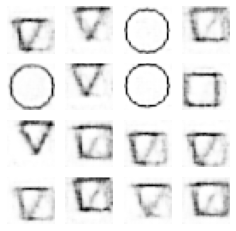

In [147]:
generate_and_save_images(model, 0, test_sample)
TIME=0
for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  MSE_metric = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    l1,l2 = compute_loss(model, test_x)
    loss(l1)
    MSE_metric(l2)
  elbo = -loss.result()
  MSE = MSE_metric.result()
  display.clear_output(wait=False)
  TIME += end_time-start_time
  print('Epoch: {}, Test set ELBO: {}, Reconstruction Error:{},  time elapse for current epoch: {}, Total Time:{}'
        .format(epoch, elbo, MSE, end_time - start_time, TIME))
  generate_and_save_images(model, epoch, test_sample)

## Latent Vector Space Visualization | Standard VAE Model

Done for training data and test data

Since our model's latent vector space is of dimension size 2, the latent vector plot below is meaningful to look at. 

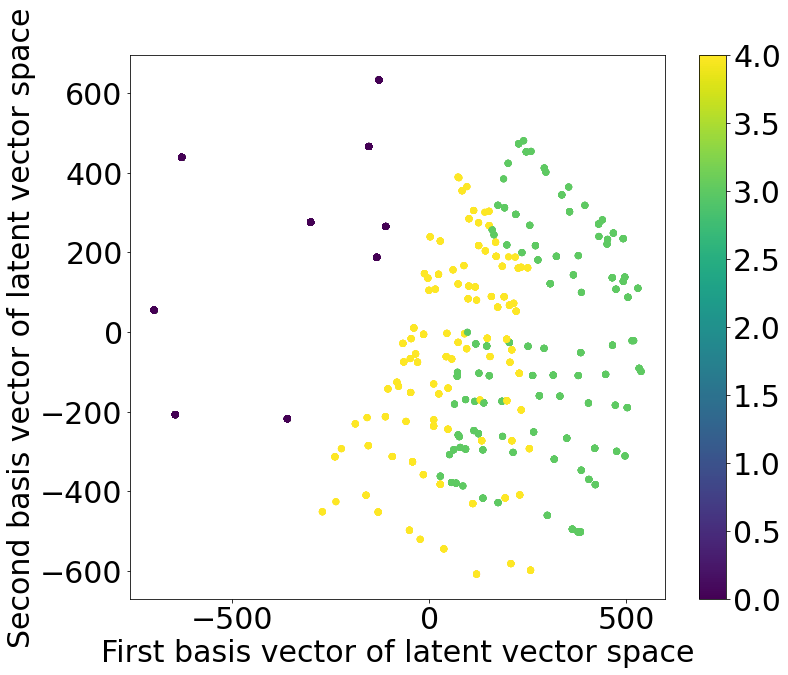

In [273]:
def plot_label_clusters(vae, N):
    # display a 2D plot of the digit classes in the latent space
    plt.rc('font', size=30)       
    xt , yt= shapeset(np.int32(N/3))
    z_mean = vae.encoder.predict(np.array(xt).reshape(-1,28,28,1))
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=yt)
    plt.colorbar()
    plt.xlabel("First basis vector of latent vector space")
    plt.ylabel("Second basis vector of latent vector space")
    plt.show()
plot_label_clusters(model, 3000)

Green represents triangles, purple represents circles, and yellow represents rectangles.

We choose to randomly sample from a normal distribution to produce 2d vectors to feed into our decoder centered around (-250,200), with a span of 400 to try  randomly construct shapes. 

# **Generate random shapes** | Experimenting with decoder for random vectors of latent dimension

In [149]:
def generate(model):
  input = tf.random.uniform([1,2],-600,600) - [0,100]
  # input = tf.random.uniform([1,2],-300,300) - [0,20]
  return model.decode(input.reshape(-1,latent_dim)).reshape(28,28)

<Figure size 432x288 with 0 Axes>

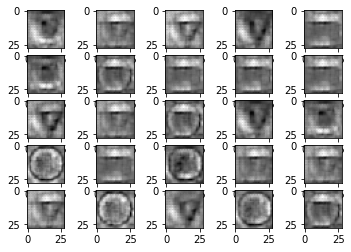

In [150]:
plt.figure()

#subplot(r,c) provide the no. of rows and columns
n=5
f, axarr = plt.subplots(n,n) 

for i in range(n):
    for j in range(n):
        axarr[i, j].imshow(generate(model),cmap = "gray")

## Estimate variance of latent vector space

A standard VAE has an unknown, but learned variance, with unknown information rate that we can attempt to estimate

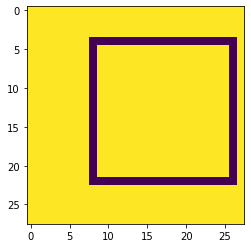

In [61]:
inputx = shapeset(1)[0][0] #First 0 is to select the x data only, second 0 is to select the first of 3 image arrays generated
plt.imshow(inputx)

$$I = d log_2(\frac{1}{\sigma^2_{\epsilon}}) $$

In [81]:
def test(model, N):
  mean = []
  for i in range(N):
    input = shapeset(1)[0][0]  #Typical image dataset input
    __,logvar = model.encode(input.reshape(1,28,28,1))
    mean.append(logvar)
    # print(logvar)
  log = np.mean(mean)
  log*=-np.log2(np.exp(1))*latent_dim
  return log


In [83]:
test(model,10000)

3984.336612639922

# **VAE_MMD Implementation**

We are now trying to replace the ELBO used for the classic VAE architecture, and influencing the latent layer to be Gaussian by having it be trained with a Maximum Mean Discrepancy MMD loss function

## Model

Same, model but with slight changes to accomodate MMD 

In [263]:
class CVAE_MMD(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE_MMD, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
        ]
    )



  def encode(self, x):
    mean =self.encoder(x)
    return mean

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

## Set the variance of noise of your choosing

In [264]:
var=.01

## MMD loss calculation function

MMD is calculated using an MMD kernel.

In [265]:
def compute_kernel(x, y):
    x_size = tf.shape(x)[0]
    y_size = tf.shape(y)[0]
    dim = tf.shape(x)[1]
    tiled_x = tf.tile(tf.reshape(x, tf.stack([x_size, 1, dim])), tf.stack([1, y_size, 1]))
    tiled_y = tf.tile(tf.reshape(y, tf.stack([1, y_size, dim])), tf.stack([x_size, 1, 1]))
    return tf.exp(-tf.reduce_mean(tf.square(tiled_x - tiled_y), axis=2) / tf.cast(dim, tf.float64))

def compute_mmd(x, y):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)
    return tf.reduce_mean(x_kernel) + tf.reduce_mean(y_kernel) - 2 * tf.reduce_mean(xy_kernel)

### Define custom functions again

In [266]:
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x, batch_size=batch_size, var=var):
  mean = model.encode(x)
  x_logit = model.decode(mean)
  mse = tf.keras.losses.MeanSquaredError()
  MSE_loss = mse(x_logit, x)  
  true_samples = tf.random.normal(tf.stack([batch_size, latent_dim]), stddev=var**.5)  
  mmd_loss = compute_mmd(true_samples,mean)
  loss_nll = tf.reduce_mean(tf.square(x - x_logit))
  return tf.reduce_sum(mmd_loss+loss_nll)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

## Training

In [267]:
epochs = 20
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model_mmd = CVAE_MMD(latent_dim)

In [268]:
def generate_and_save_images(model, epoch, test_sample):
  mean = model.encode(test_sample)
  predictions = model.decode(mean)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [269]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

### Generate as we train

Epoch: 20, Test set ELBO: -0.05717746168375015, time elapse for current epoch: 11.698874711990356, Total Time:236.0481300354004


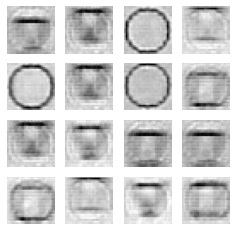

In [270]:
generate_and_save_images(model_mmd, 0, test_sample)
TIME=0
for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    # train_step(model, train_x, optimizer)
    train_step(model_mmd, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  MSE_metric = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    # loss(compute_loss(model, test_x))
    # loss(compute_loss(model_mmd, test_x))
    # l1,l2 = compute_loss(model_mmd, test_x)
    l1 = compute_loss(model_mmd, test_x)
    loss(l1)
    # MSE_metric(l2)    
  elbo = -loss.result()
  # MSE = MSE_metric.result()  
  TIME += end_time-start_time
  display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}, Total Time:{}'
        .format(epoch, elbo,end_time - start_time, TIME))
  # generate_and_save_images(model, epoch, test_sample)
  generate_and_save_images(model_mmd, epoch, test_sample)

## Latent Vector Space Visualisation | MMD Model

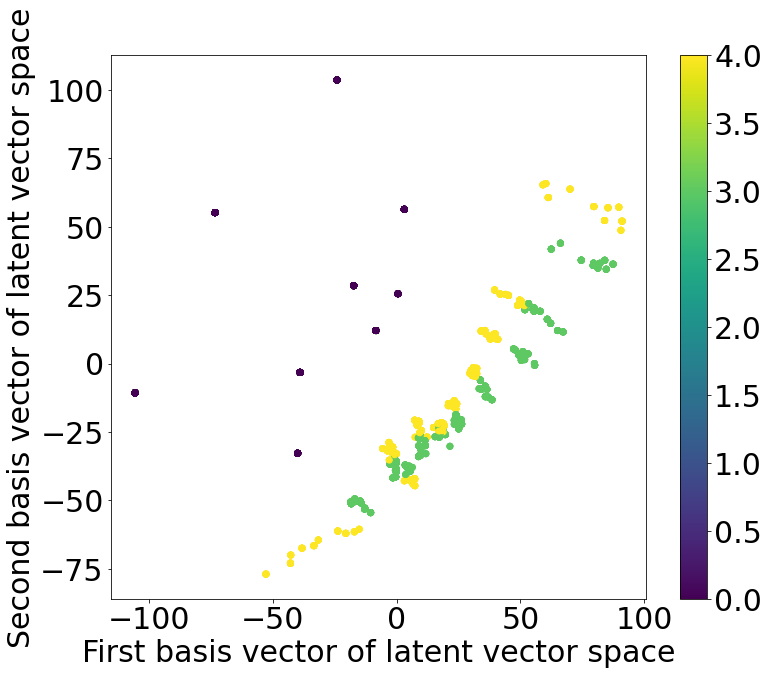

In [187]:
def plot_label_clusters(vae, N):
    plt.rc('font', size=30)   
    # display a 2D plot of the digit classes in the latent space
    xt , yt= shapeset(np.int32(N/3))
    z_mean = vae.encoder.predict(np.array(xt).reshape(-1,28,28,1))
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=yt)
    plt.colorbar()
    plt.xlabel("First basis vector of latent vector space")
    plt.ylabel("Second basis vector of latent vector space")
    plt.show()

plot_label_clusters(model_mmd, 3000)

Here is the cluster plot for the MMD model, if we had chosen to run sigmoid on the final layer. The actual MMD cluster plot for this current running model is at the bottom.

In [260]:
def generate_mmd(model):
  input = tf.random.uniform([1,2],-600,600) 
  return model.decode(input.reshape(-1,latent_dim)).reshape(28,28)

<Figure size 432x288 with 0 Axes>

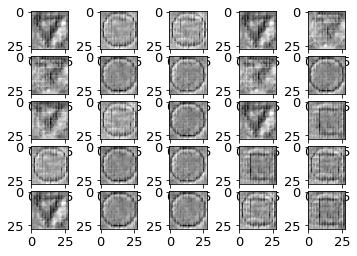

In [261]:
plt.figure()
plt.rc('font', size=13)   
#subplot(r,c) provide the no. of rows and columns
n=5
f, axarr = plt.subplots(n,n) 

for i in range(n):
    for j in range(n):
        axarr[i, j].imshow(generate_mmd(model_mmd),cmap = "gray")

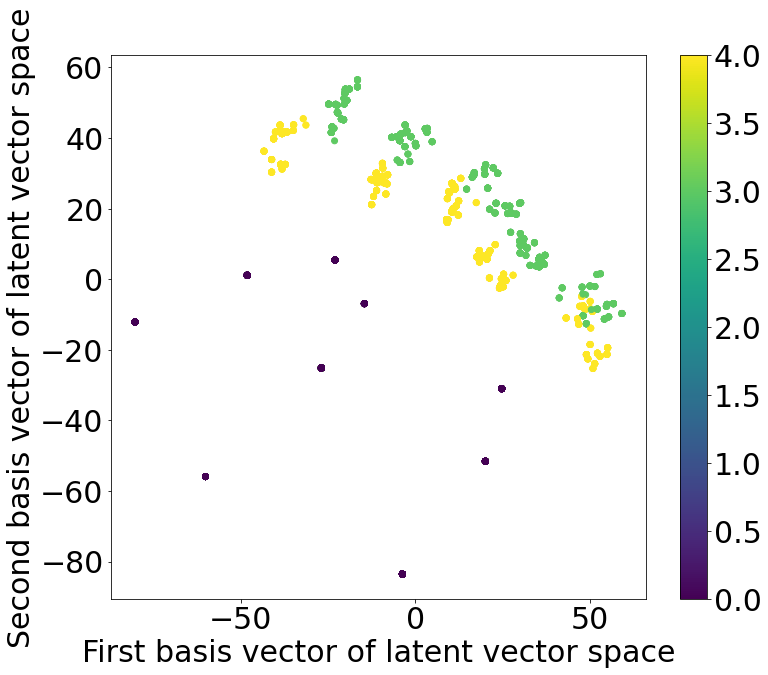

In [271]:
def plot_label_clusters(vae, N):
    plt.rc('font', size=30)   
    # display a 2D plot of the digit classes in the latent space
    xt , yt= shapeset(np.int32(N/3))
    z_mean = vae.encoder.predict(np.array(xt).reshape(-1,28,28,1))
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=yt)
    plt.colorbar()
    plt.xlabel("First basis vector of latent vector space")
    plt.ylabel("Second basis vector of latent vector space")
    plt.show()

plot_label_clusters(model_mmd, 3000)